In [113]:
# import libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [114]:
data= pd.read_csv('test_diabetes.csv',sep=';')

In [115]:
#Let's check the type of data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               731 non-null    float64
 1   Glucose                   730 non-null    float64
 2   BloodPressure             734 non-null    float64
 3   SkinThickness             734 non-null    float64
 4   Insulin                   717 non-null    object 
 5   BMI                       733 non-null    float64
 6   DiabetesPedigreeFunction  728 non-null    float64
 7   Age                       717 non-null    float64
 8   Outcome                   768 non-null    object 
dtypes: float64(7), object(2)
memory usage: 54.1+ KB


In [116]:
# Let's replace the text values and change the data into numerical and process illogic data
data['Insulin'] = data['Insulin'].replace({'Zero':0}).apply(lambda x: int(x) if isinstance(x, str)  else x)
data['Outcome'] = data['Outcome'].replace({'N':0, 'Y':1}).apply(lambda x:int(x))
data['Age'] =  data['Age'].apply(lambda x:np.NaN if (x<0 or x>100) else x)

In [117]:
features = data[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin','BMI']].applymap(lambda x: np.NaN if x==0 else x)
data= pd.concat([features , data[['Pregnancies','DiabetesPedigreeFunction', 'Age','Outcome']]],axis=1)

In [118]:
#Let's redifine X and y
X= data.iloc[:,:-1]
y= data.iloc[:,-1]

In [135]:
# We split the data in training set 75% and test set 25% of total dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, random_state = 40 ,stratify=y)

In [120]:
list_columns =data.columns
list_columns

Index(['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI',
       'Pregnancies', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [121]:
Visualise_Data = data.applymap( lambda x: 'Non Zero'  if (x>0) else ( 'ZERO' if (x==0) else 'NAN' ))

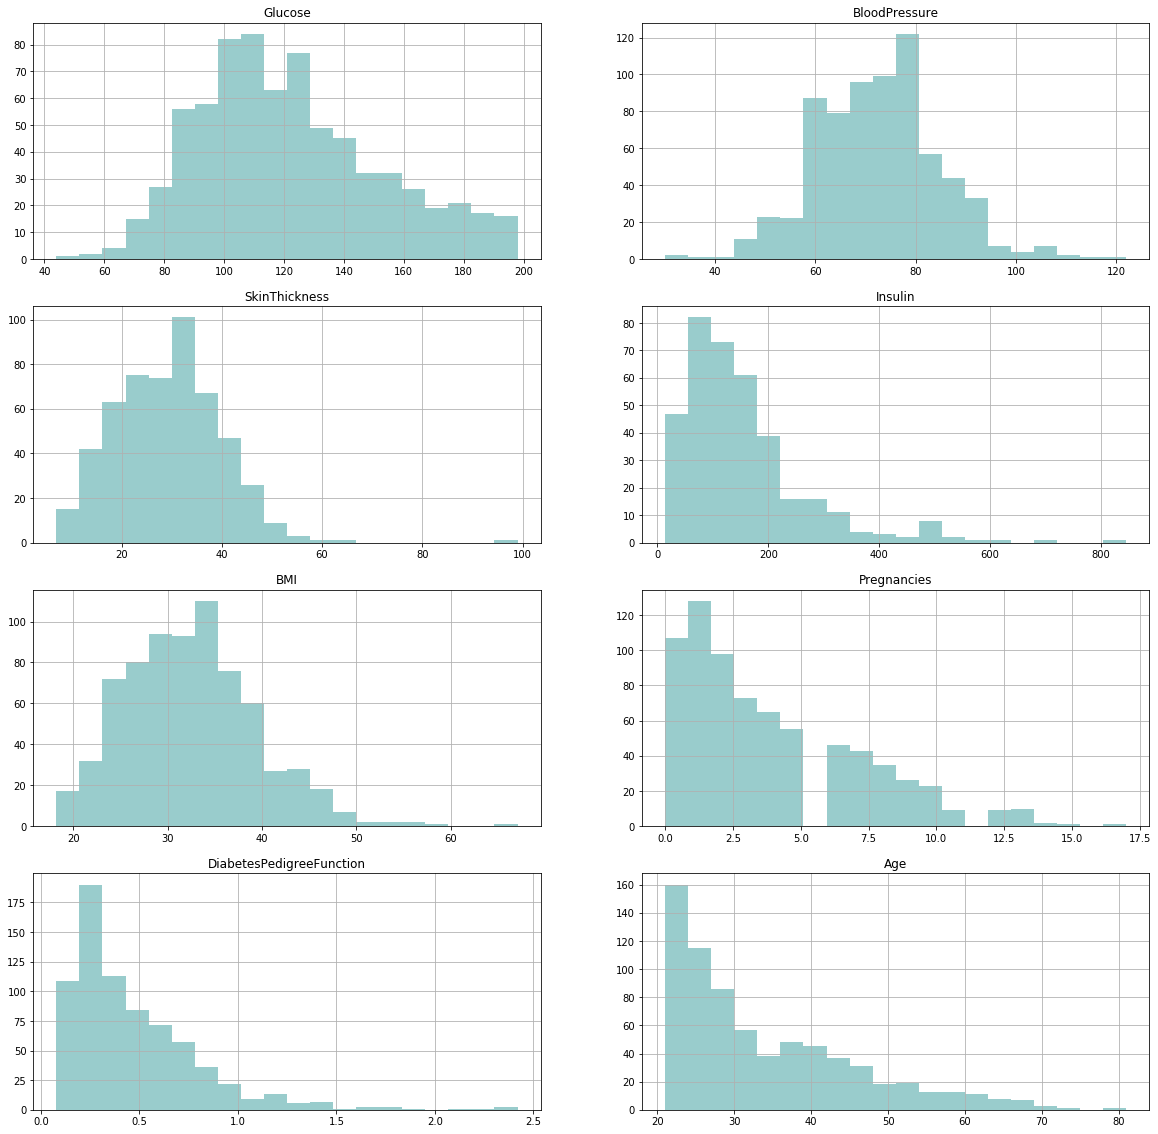

In [122]:
fig,axes = plt.subplots(4,2, figsize=(20, 20))
for i,ax in enumerate(axes.flatten()):
    data.iloc[:,i].hist(bins=20, color='teal', alpha=0.4, ax=ax).set_title(list_columns[i])  
    #sns.distplot(data.iloc[:, i] , bins=20,     ax=ax)

In [123]:
Visualise_Data = data.rename(columns={'DiabetesPedigreeFunction':'DPF'}).iloc[:,:-1].applymap( lambda x: 'NON ZERO'  if (x>0) else ( 'ZERO' if (x==0) else 'NAN' ))

In [124]:
Visualise_Data.head() 

,Glucose,BloodPressure,SkinThickness,Insulin,BMI,Pregnancies,DPF,Age
0,NON ZERO,NON ZERO,NON ZERO,NAN,NON ZERO,NAN,NON ZERO,NON ZERO
1,NON ZERO,NON ZERO,NON ZERO,NAN,NON ZERO,NON ZERO,NON ZERO,NON ZERO
2,NON ZERO,NON ZERO,NAN,NAN,NON ZERO,NON ZERO,NON ZERO,NON ZERO
3,NON ZERO,NON ZERO,NON ZERO,NON ZERO,NON ZERO,NON ZERO,NON ZERO,NON ZERO
4,NAN,NON ZERO,NON ZERO,NON ZERO,NON ZERO,ZERO,NON ZERO,NAN


In [125]:
List_Values = pd.DataFrame()
values = 0
for col in Visualise_Data.columns:
    values = Visualise_Data[col].value_counts().to_frame()
    List_Values =  pd.concat([List_Values,values],axis=1)
List_Values

,Glucose,BloodPressure,SkinThickness,Insulin,BMI,Pregnancies,DPF,Age
NON ZERO,726.0,699.0,525.0,368.0,722.0,624,728.0,711.0
NAN,42.0,69.0,243.0,400.0,46.0,37,40.0,57.0
ZERO,NaN,NaN,NaN,NaN,NaN,107,NaN,NaN


<Figure size 1440x720 with 0 Axes>

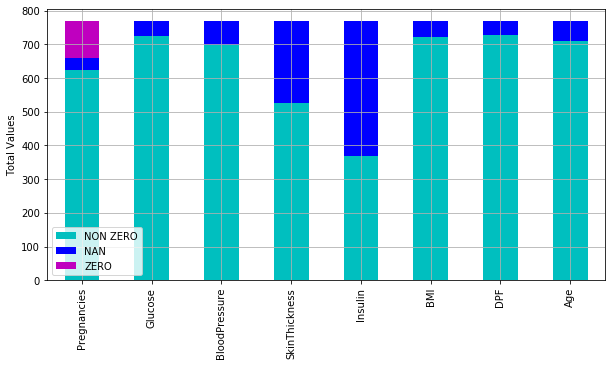

In [126]:
plt.figure(figsize=(20,10))
List_Values.T.sort_values('ZERO', ascending = False).plot(kind='bar', stacked=True  , color='cbm' ,figsize=(10,5))
plt.ylabel('Total Values')
plt.grid()

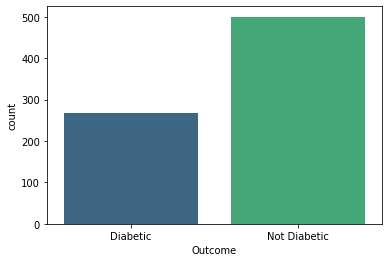

In [127]:
sns.countplot(data['Outcome'].replace({0:'Not Diabetic', 1:'Diabetic'}),palette='viridis' ,)

In [128]:
print( "The minority class percentage in the global dataset:",
       "{:0.2%}".format(data['Outcome'].value_counts()[1]/data['Outcome'].value_counts().sum())
      )

The minority class percentage in the global dataset: 34.90%


In [129]:
data['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [130]:
# import pipeline architecture models
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler , StandardScaler
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.pipeline import Pipeline

In [131]:
class Prediction_Output:
  def __init__(self, y_pred, best_params , best_model):
    self.y_pred = y_pred
    self.best_params = best_params
    self.best_model = best_model

In [132]:
def CreatePrediction_grid_Test2 (model, X_train , y_train , X_test , **kwargs ) :
    from sklearn.model_selection import GridSearchCV
    from sklearn.preprocessing import MinMaxScaler , StandardScaler
    from sklearn.impute import SimpleImputer,KNNImputer
    from sklearn.pipeline import Pipeline
    
    Grid_param = kwargs.get('grid', None)
    Search_type = kwargs.get('gridsearch', None)
    kfold = kwargs.get('cv',None)
    scoring_metrics= kwargs.get('Scoring_Function', None)
    #imputer= kwargs.get('imputer', SimpleImputer())

    
  
    
    steps = [('imputer', KNNImputer()),('scaler', StandardScaler()), ('model', model )]
    pipeline = Pipeline(steps)
    classifier = GridSearchCV(pipeline,Grid_param,cv=kfold,verbose=1,n_jobs=-1,scoring=scoring_metrics ) 
    classifier.fit(X_train,y_train)
    y_pred=classifier.predict(X_test)
    
    
    pred =Prediction_Output(y_pred,classifier.best_params_,classifier.best_estimator_)
     
        
    return pred


In [133]:
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
# create a function to evalue y test
def Calculate_peformance(y_test , y_pred):
        cm = confusion_matrix(y_test, y_pred)
        acc= accuracy_score(y_test, y_pred )
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1score =  f1_score(y_test, y_pred, average='weighted')
        roc =  roc_auc_score(y_test, y_pred, average='weighted')
        result={'model' : ['Model'] , 'accuracy' : [acc],'precision' : [precision] , 'recall' : [recall] , 'F1score' : [f1score]  , 'AUC_ROC' : [roc]  }
        result = pd.DataFrame.from_dict( result)
        return result
    

In [136]:


 
grid_SVM ={'model__C': [0.1, 1, 10, 100, 1000],   #0.1, 1, 10, 100, 1000
           'model__gamma': [  1, 0.1, 0.01, 0.001, 0.0001], #1, 0.1, 0.01, 0.001, 0.0001
           'model__kernel': ['rbf'],
           #'imputer__strategy': ['mean'] #['mean', 'median', 'most_frequent']
           'imputer__n_neighbors':[2,3,4,5,6,7,8,9,10,11,12,13]#2,3,4,5,6,7,8
          }  
from sklearn.svm import SVC
classifier_SVM = SVC(kernel = 'rbf', random_state = 0)

 
pred = CreatePrediction_grid_Test2(classifier_SVM,X_train,y_train,X_test,grid=grid_SVM,gridsearch=True,cv=5,Scoring_Function='accuracy')
result = Calculate_peformance(y_test,pred.y_pred)
print(result)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    6.3s


   model  accuracy  precision    recall   F1score   AUC_ROC
0  Model  0.760417   0.754328  0.760417  0.754121  0.715582


[Parallel(n_jobs=-1)]: Done 1485 out of 1500 | elapsed:   13.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:   13.1s finished


In [137]:
pred.best_params

{'imputer__n_neighbors': 2,
 'model__C': 1000,
 'model__gamma': 0.0001,
 'model__kernel': 'rbf'}

{'imputer__n_neighbors': 5,
 'model__C': 100,
 'model__gamma': 0.01,
 'model__kernel': 'rbf'}

In [142]:
grid_RF ={'model__n_estimators':  [200,300,400,500], #[200,300,400]
       'model__max_features' : [ 'log2'], #['auto', 'sqrt', 'log2']
       'model__max_depth':  [5,6 ], #[4,5,6,7,8]
       'model__min_samples_split': [ 6,7,8 ],
       'model__min_samples_leaf': [2],
       'model__bootstrap': [ True],
       'model__criterion': [ 'entropy'],
       'imputer__n_neighbors':[3,5,7,9 ]}

from sklearn.ensemble import RandomForestClassifier
classifier_RFC = RandomForestClassifier()

 
pred = CreatePrediction_grid_Test2(classifier_RFC,X_train,y_train,X_test,grid=grid_RF,gridsearch=True,cv=5,Scoring_Function='accuracy')
result = Calculate_peformance(y_test,pred.y_pred)
print(result)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  1.2min finished


   model  accuracy  precision    recall  F1score   AUC_ROC
0  Model  0.723958   0.723023  0.723958  0.72347  0.694507


In [143]:
pred.best_params

{'imputer__n_neighbors': 7,
 'model__bootstrap': True,
 'model__criterion': 'entropy',
 'model__max_depth': 6,
 'model__max_features': 'log2',
 'model__min_samples_leaf': 2,
 'model__min_samples_split': 7,
 'model__n_estimators': 400}

In [105]:
#iterate the gridsearch 100 times 10 fold in order to check the variance in the result
results = pd.DataFrame(columns = ['model','accuracy','precision','recall','F1score','AUC_ROC'])
for i in range(1,50):
    grid_RF ={'model__n_estimators':  [400], #[200,300,400]
       'model__max_features' : [   'log2'], #['auto', 'sqrt', 'log2']
       'model__max_depth':  [ 5 ], #[4,5,6,7,8]
       'model__min_samples_split': [8 ],
       'model__min_samples_leaf': [2  ],
       'model__bootstrap': [ True],
       'model__criterion': [ 'entropy'],
       'imputer__n_neighbors':[3 ]}

    from sklearn.ensemble import RandomForestClassifier
    classifier_RFC = RandomForestClassifier()

 
    pred = CreatePrediction_grid_Test2(classifier_RFC,X_train,y_train,X_test,grid=grid_RF,gridsearch=True,cv=10,Scoring_Function='accuracy')
    result = Calculate_peformance(y_test,pred.y_pred)
    
    results =  pd.concat([results,result],axis=0)


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.4s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.9s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.4s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.9s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.5s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.0s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.5s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.1s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    3.1s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.4s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    3.1s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.5s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    3.2s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.4s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.5s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.1s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.4s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.9s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.4s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.8s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.6s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.0s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.3s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.1s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.5s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.0s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.4s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.0s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.6s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.3s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.5s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.0s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.5s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.0s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.5s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.0s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.5s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.8s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.5s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.0s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.5s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.2s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.5s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.0s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.6s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.1s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.5s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.0s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.5s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.0s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.5s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.0s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.6s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.1s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.5s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.0s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.5s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.9s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.5s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.0s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.6s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.1s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.8s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.1s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.5s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.0s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.5s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.0s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.5s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.0s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.5s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.1s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.5s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.9s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.7s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.2s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.8s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.4s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.5s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.1s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.7s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.6s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.4s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.9s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.4s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.0s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.5s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.0s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.5s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.0s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.5s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.0s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.5s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.0s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.5s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.0s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.5s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.1s finished


In [106]:
# save the iteration in a csv file
results.to_csv('RandForest_0toNan_CV_Iteration', index = False, header=True)

In [107]:
result_100_10CV_RF_Hyp1 = results.mean()
result_100_10CV_RF_Hyp1

accuracy     0.742985
precision    0.740620
recall       0.742985
F1score      0.731902
AUC_ROC      0.699723
dtype: float64

In [141]:
grid_XGB = {
        'model__min_child_weight': [1, 5, 10],
        'model__gamma': [0.5, 1, 1.5, 2, 5],
        'model__subsample': [0.6, 0.8, 1.0],
        'model__colsample_bytree': [0.6, 0.8, 1.0],
        'model__max_depth': [3, 4, 5],
        'imputer__n_neighbors':[3,4,5 ]
        }

#fitting XGBOOST
from xgboost import XGBClassifier
classifier_XGBOOST = XGBClassifier(random_state = 0,n_jobs=-1) 

 
pred = CreatePrediction_grid_Test2(classifier_XGBOOST,X_train,y_train,X_test,grid=grid_XGB,gridsearch=True,cv=5,Scoring_Function='accuracy')
result = Calculate_peformance(y_test,pred.y_pred)
print(result)

Fitting 5 folds for each of 1215 candidates, totalling 6075 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
C:\Users\User\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 724 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 1424 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 2324 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done 3424 tasks      | elapsed:   47.8s
[Parallel(n_jobs=-1)]: Done 4724 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 6060 out of 6075 | elapsed:  1.5min remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 6075 out of 6075 | elapsed:  1.5min finished


   model  accuracy  precision    recall   F1score   AUC_ROC
0  Model  0.744792   0.749783  0.744792  0.746778  0.727821


In [79]:
pred.best_params

{'imputer__n_neighbors': 6,
 'model__colsample_bytree': 0.6,
 'model__gamma': 1.5,
 'model__max_depth': 3,
 'model__min_child_weight': 1,
 'model__subsample': 0.8}

In [144]:


grid_KNN ={'model__n_neighbors': np.arange(5,13),
           'model__weights':['uniform','distance'],
           'model__metric':['minkowski', 'euclidean','manhattan'],
           'imputer__n_neighbors':[3,4,5,6,7]
          }


from sklearn.neighbors import KNeighborsClassifier
classifier_KNN = KNeighborsClassifier()

 
pred = CreatePrediction_grid_Test2(classifier_KNN,X_train,y_train,X_test,grid=grid_KNN,gridsearch=True,cv=5,Scoring_Function='accuracy')
result = Calculate_peformance(y_test,pred.y_pred)
print(result)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    6.4s


   model  accuracy  precision    recall   F1score   AUC_ROC
0  Model  0.765625   0.766463  0.765625  0.766022  0.743821


[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:   10.6s finished


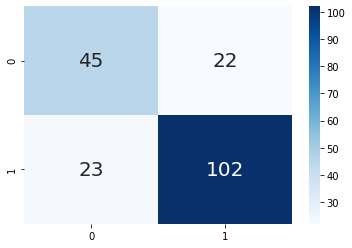

In [145]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,pred.y_pred,labels=[1, 0])
sns.heatmap(cm , annot=True ,fmt='d',cmap='Blues',  annot_kws={"size":20})

In [40]:
pred.best_params

{'imputer__n_neighbors': 4,
 'model__metric': 'manhattan',
 'model__n_neighbors': 11,
 'model__weights': 'uniform'}

In [140]:
grid_LR = {"model__C":np.logspace(-3,3,7),
           "model__penalty":["l1","l2"],
           'imputer__n_neighbors':[3,4,5,6,7]
          }

from sklearn.linear_model import LogisticRegression
classifier_LR = LogisticRegression( ) 

 
pred = CreatePrediction_grid_Test2(classifier_LR,X_train,y_train,X_test,grid=grid_LR,gridsearch=True,cv=5,Scoring_Function='accuracy')
result = Calculate_peformance(y_test,pred.y_pred)
print(result)

Fitting 5 folds for each of 70 candidates, totalling 350 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s


   model  accuracy  precision  recall   F1score   AUC_ROC
0  Model      0.75   0.744648    0.75  0.745939  0.711045


[Parallel(n_jobs=-1)]: Done 350 out of 350 | elapsed:    1.7s finished


In [98]:
pred.best_params

{'imputer__n_neighbors': 4, 'model__C': 100.0, 'model__penalty': 'l2'}

In [212]:
pred.best_params

{'imputer__n_neighbors': 3,
 'model__metric': 'manhattan',
 'model__n_neighbors': 9,
 'model__weights': 'uniform'}